# Refugee Population Analysis & Prediction (Rukban, Syria)

In [2]:
import requests as req
import sentinelhub as sh
import matplotlib.pyplot as plt
import numpy as np
import cv2
import mimetypes
import sentinelhub.constants
from PIL import Image
import numpy as np
from spectral import *
import pandas as pd
from fbprophet import Prophet
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
%matplotlib notebook
%matplotlib inline

### Load Satellite Imagery

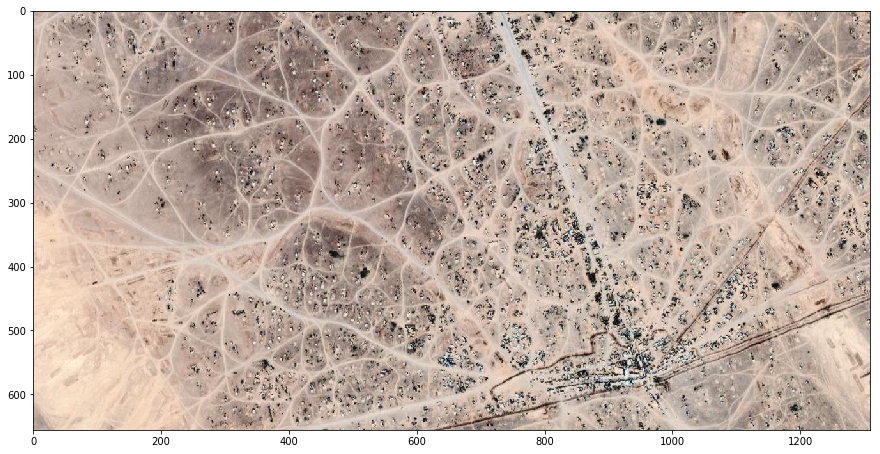

In [3]:
im = Image.open('rukban_demo.png')
imarray = np.array(im)
fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
plt.imshow(imarray)

### K-means Clustering of Structures

Initializing clusters along diagonal of N-dimensional bounding box.
Iteration 1...  0.Iteration 1...858435 pixels reassigned.
Iteration 2...  0.Iteration 2...58342 pixels reassigned.
Iteration 3...  0.Iteration 3...52664 pixels reassigned.
Iteration 4...  0.Iteration 4...46194 pixels reassigned.
Iteration 5...  0.Iteration 5...45535 pixels reassigned.
Iteration 6...  0.Iteration 6...41680 pixels reassigned.
Iteration 7...  0.Iteration 7...40417 pixels reassigned.
Iteration 8...  0.Iteration 8...38619 pixels reassigned.
Iteration 9...  0.Iteration 9...33574 pixels reassigned.
Iteration 10...  0.0Iteration 10...28461 pixels reassigned.
Iteration 11...  0.0Iteration 11...23279 pixels reassigned.
Iteration 12...  0.0Iteration 12...22411 pixels reassigned.
Iteration 13...  0.0Iteration 13...19423 pixels reassigned.
Iteration 14...  0.0Iteration 14...16518 pixels reassigned.
Iteration 15...  0.0Iteration 15...15847 pixels reassigned.
Iteration 16...  0.0Iteration 16...14849 pixels reassigned

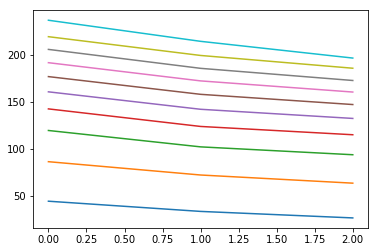

In [4]:
(m, c) = kmeans(imarray, 10, 100)
plt.figure()

for i in range(c.shape[0]):
    plt.plot(c[i])

plt.show()

### K-means Clustered Image

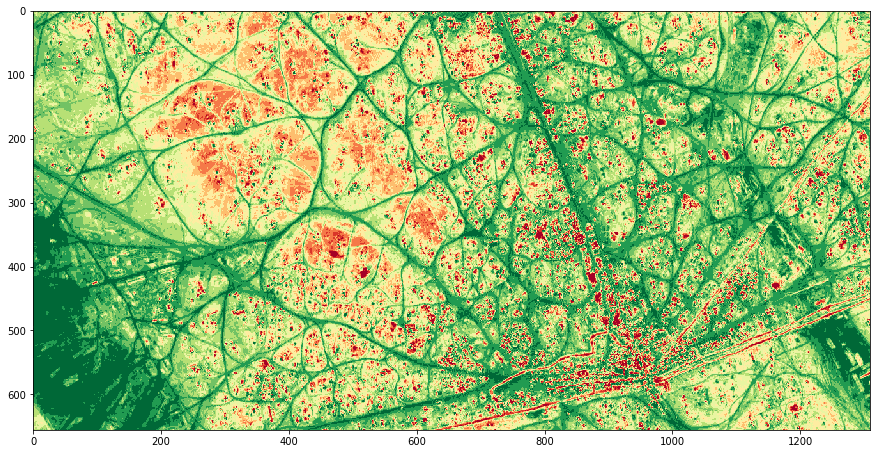

In [5]:
fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
plt.imshow(m, cmap='RdYlGn')

### Binary Filter on K-means Clustered Image

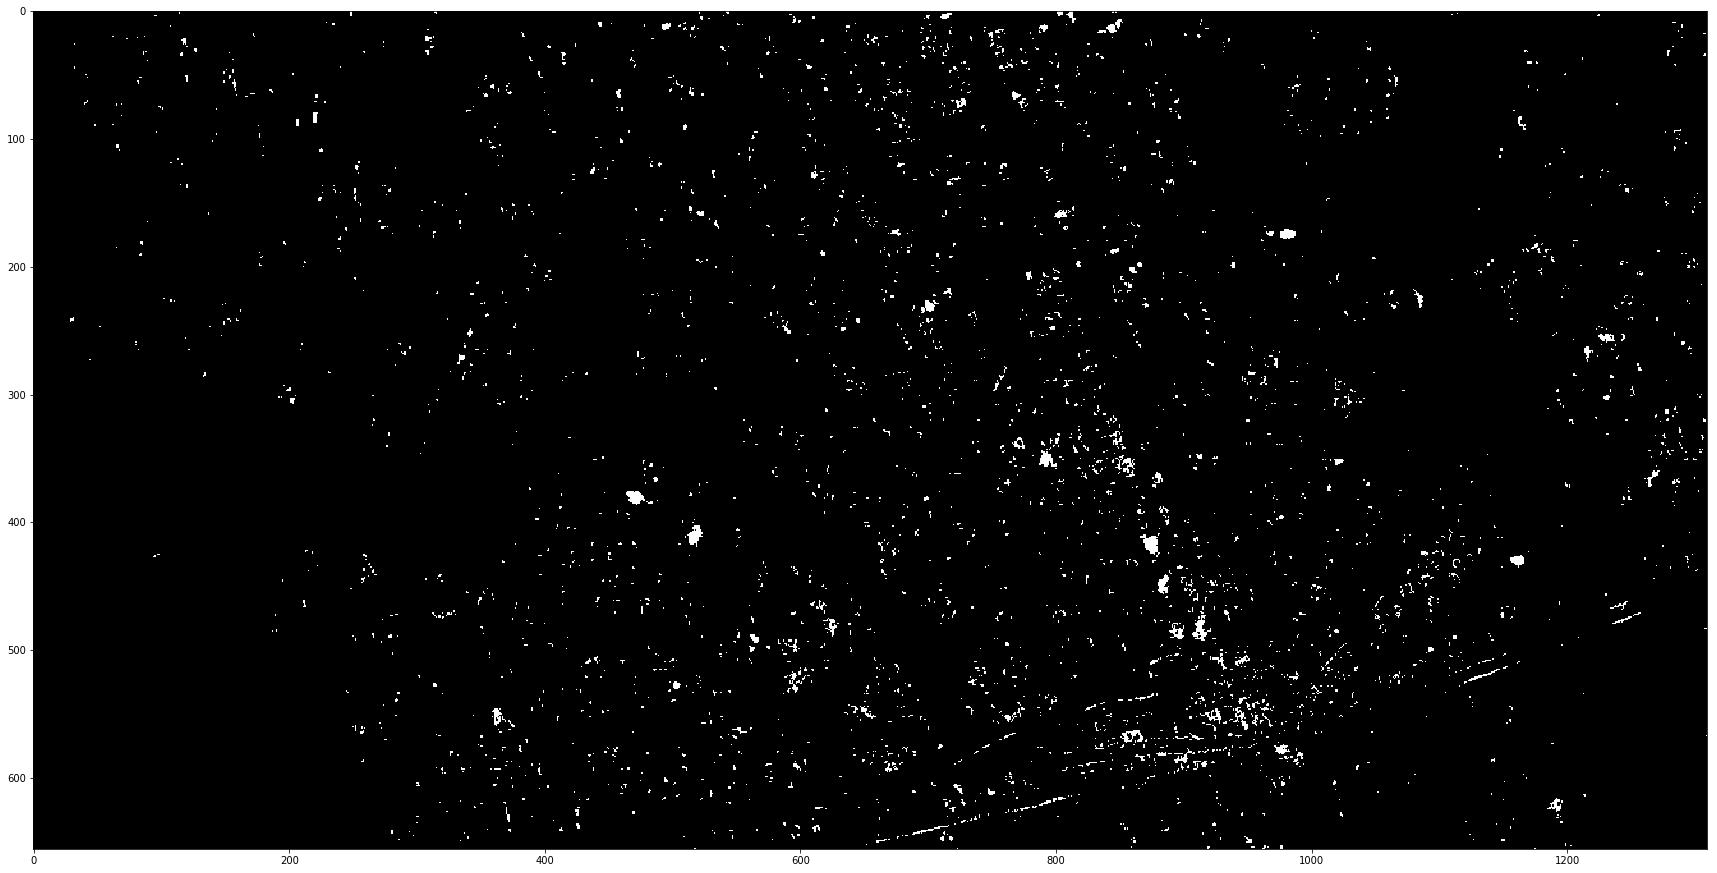

In [6]:
filteredm = np.copy(m)
filteredm[filteredm>0] = 1
fig = plt.subplots(nrows=1, ncols=1, figsize=(30, 30))
plt.imshow(filteredm, cmap='binary')

### Blob detection with sklearn

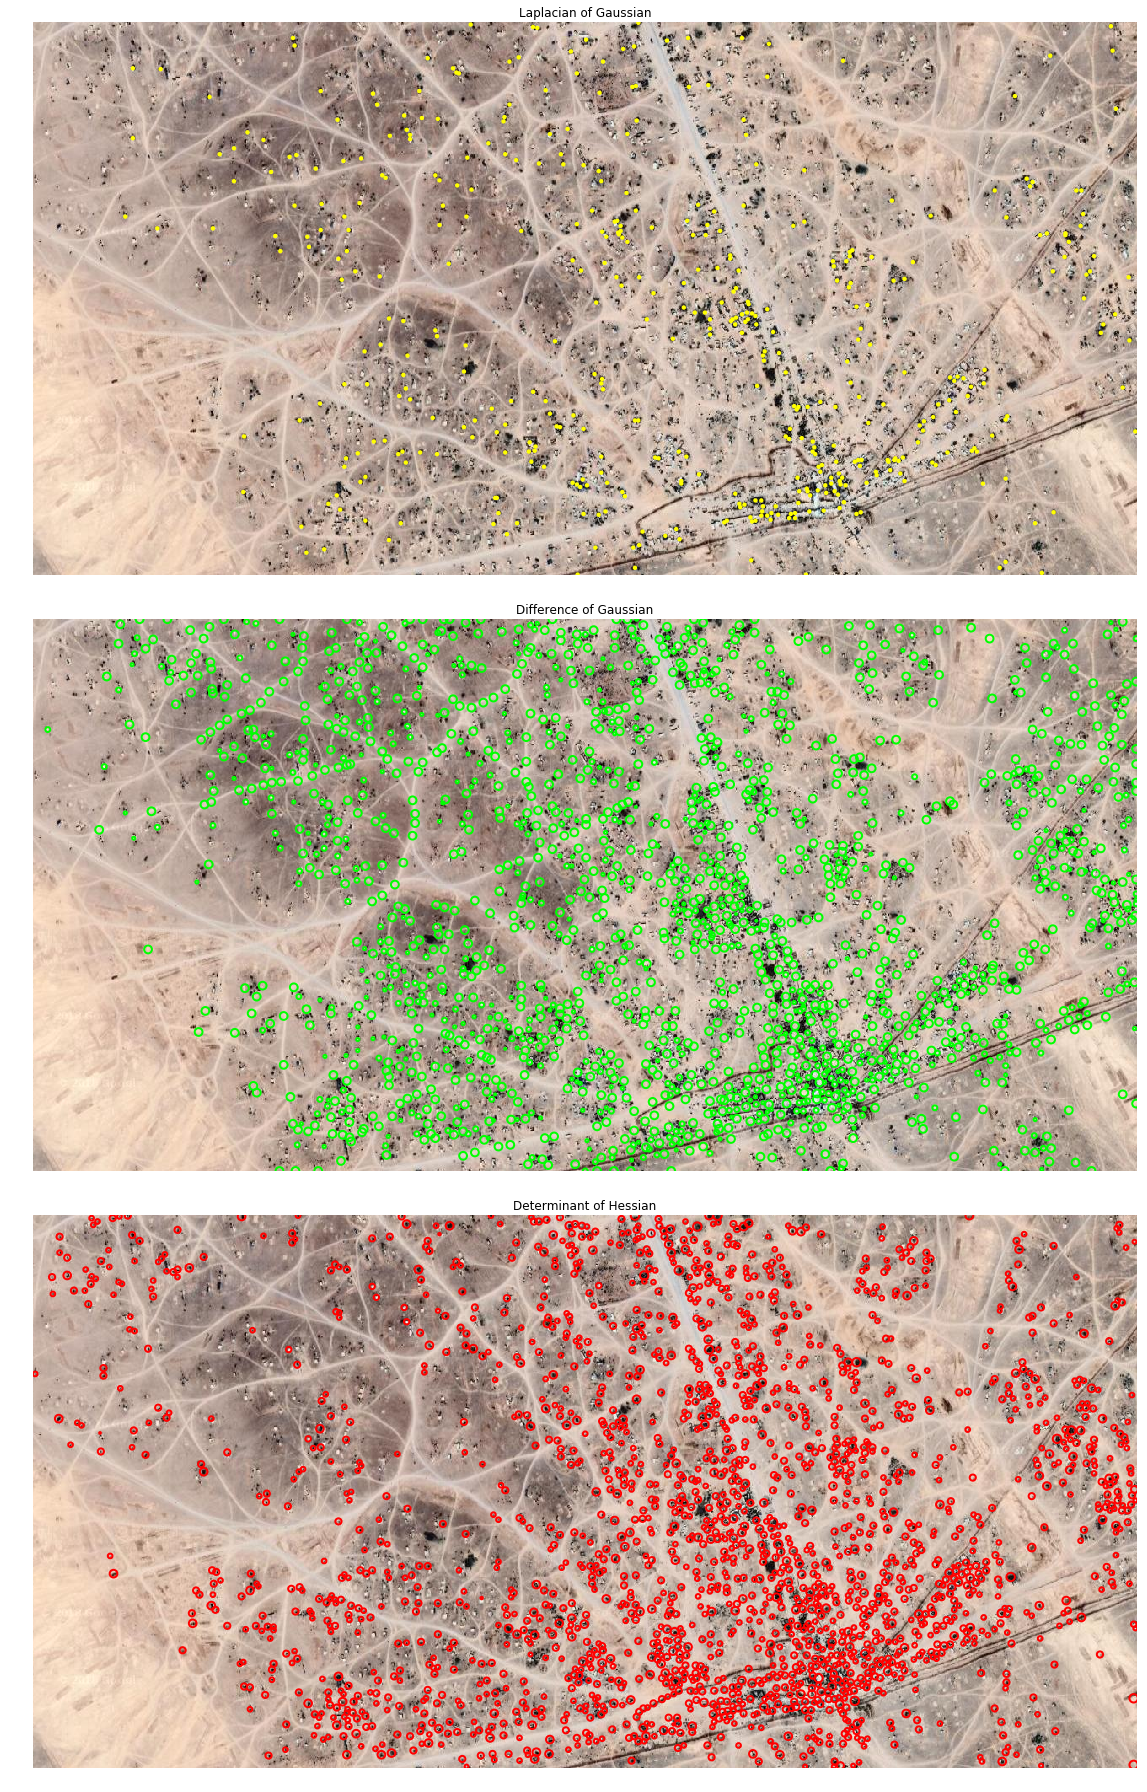

In [12]:
image_gray = rgb2gray(imarray)
blobs_log = blob_log(image_gray)
#blob_log(image_gray, min_sigma=.01, max_sigma=10, num_sigma=5, threshold=.01)

blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)
blobs_dog = blob_dog(image_gray, min_sigma=.5, max_sigma=5, threshold=.1)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

blobs_doh = blob_doh(image_gray, max_sigma=5, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(3, 1, figsize=(30,25))
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(imarray, interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
len(blobs_log), len(blobs_dog), len(blobs_doh)

In [ ]:
plt.imshow(imarray, figsize=(30, 30))

## Time Series Analysis with FB Prophet

In [ ]:
# Load Data
rukban_df = pd.read_csv('rukban_time_series.txt')
rukban_df.head(10)

In [ ]:
# Prepare data for FB Prophet
rukban_df = rukban_df.drop(['PRODUCT ID'], axis=1)
rukban_df = rukban_df.rename(index=str, columns={'DATE OF IMAGE': 'date', 'SHELTER COUNT': 'shelter_count'})
rukban_df.head()

In [ ]:
X = pd.DataFrame(index=range(0,len(rukban_df)))
X['ds'] = rukban_df.date.values
X['y'] = rukban_df.shelter_count.values
X.tail()

In [ ]:
# Create FB Prophet instance & fit data
model = Prophet()  #daily_seasonality=True
model.fit(X)

In [ ]:
# Forecast refugee camp population 3 months out
future = model.make_future_dataframe(periods=3)
future.tail(20)
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
# FB Prophet Time Series Forecast Plots
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)

### SIFT (Scale-Invariant Feature Transform) with OpenCV

In [ ]:
# Read image
im = cv2.imread('kmeans_filtered_2.png')
#cv2.imread('kmeans.png', cv2.IMREAD_GRAYSCALE)

# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 10
params.maxThreshold = 200

# Filter by Area.
params.filterByArea = True
params.minArea = 1500

# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.1

# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.87
    
# Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.01

# Create a detector with the parameters
ver = (cv2.__version__).split('.')
if int(ver[0]) < 3 :
    detector = cv2.SimpleBlobDetector(params)
else : 
    detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs.
keypoints = detector.detect(im)

# Draw detected blobs as red circles
im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show blobs
cv2.imshow("Keypoints", im_with_keypoints)
cv2.waitKey(0)

### SURF (Speeded-Up Robust Features) with OpenCV

In [ ]:
img = cv2.imread('kmeans_filtered_2.png',0)
# Hessian Threshold to 400
surf = cv2.SURF(400)
# Find keypoints and descriptors directly
kp, des = surf.detectAndCompute(img,None)
len(kp)

### Sentinal API Code

In [ ]:
base_url = 'http://services.sentinel-hub.com/ogc/wms/'
instance_id = inid.instance_id()

In [ ]:
test = req.get('http://services.sentinel-hub.com/ogc/wms/420323a2-e3b4-45f3-bd98-e7d353665736?REQUEST=GetMap&BBOX=3238005,5039853,3244050,5045897&LAYERS=TRUE_COLOR&MAXCC=20&WIDTH=320&HEIGHT=320&FORMAT=image/jpeg&TIME=2016-01-29/2016-02-29')
test.status_code

In [ ]:
def plot_image(image, factor=1):
    """
    Utility function for plotting RGB images.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(30, 30))

    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1))
    else:
        plt.imshow(image)

In [ ]:
coords_wgs84 = [38.6, 33.3, 38.65, 33.35]
betsiboka_bbox = sh.BBox(bbox=coords_wgs84, crs=sh.CRS.WGS84)

In [ ]:
wms_true_color_request = sh.WmsRequest(layer='FALSE_COLOR_URBAN',
                                    bbox=betsiboka_bbox,
                                    time=('2008-1-15','2018-1-15'),
                                    width=1024,
                                    image_format=sh.constants.MimeType.TIFF_d32f,
                                    maxcc=0.0,
                                    instance_id=instance_id)

In [ ]:
wms_true_color_img = wms_true_color_request.get_data()
dates = wms_true_color_request.get_dates()

In [ ]:
wms_true_color_img[0].dtype
dates[0]
len(wms_true_color_img)